In [5]:
# !mkdir ~/.kaggle
# !cp ./drive/MyDrive/DL/kaggle/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [6]:
# !kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:09<00:00, 71.8MB/s]
100% 812M/812M [00:09<00:00, 85.7MB/s]


In [7]:
# !unzip -qq dogs-vs-cats.zip

In [8]:
# !unzip -qq train.zip

In [9]:
import os, shutil, pathlib

# original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

# def make_subset(subset_name, start_index, end_index):
#     for category in ("cat", "dog"):
#         dir = new_base_dir / subset_name / category
#         os.makedirs(dir)
#         fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
#         for fname in fnames:
#             shutil.copyfile(src=original_dir / fname,
#                             dst=dir / fname)

# make_subset("train", start_index=0, end_index=1000)
# make_subset("validation", start_index=1000, end_index=1500)
# make_subset("test", start_index=1500, end_index=2500)

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [2]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [10]:
# data preprocessing
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


#### Fast feature extraction without data augmentation

In [11]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [12]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 21ms/step


In [13]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [15]:
from keras import layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [16]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

In [18]:
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 4s 11ms/step - loss: 14.8529 - accuracy: 0.9245 - val_loss: 14.9776 - val_accuracy: 0.9270
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 3.7670 - accuracy: 0.9750 - val_loss: 4.2042 - val_accuracy: 0.9710
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.9217 - accuracy: 0.9835 - val_loss: 5.7973 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 2.0709 - accuracy: 0.9885 - val_loss: 4.5144 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6503 - accuracy: 0.9940 - val_loss: 4.5854 - val_accuracy: 0.9790
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.7344 - accuracy: 0.9925 - val_loss: 4.4347 - val_accuracy: 0.9820
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.5396 - accuracy: 0.9945 - val_loss: 5.8577 - val_accuracy: 0.9810
Epoch 8/20
63/63 

In [19]:
import matplotlib.pyplot as plt


def show_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

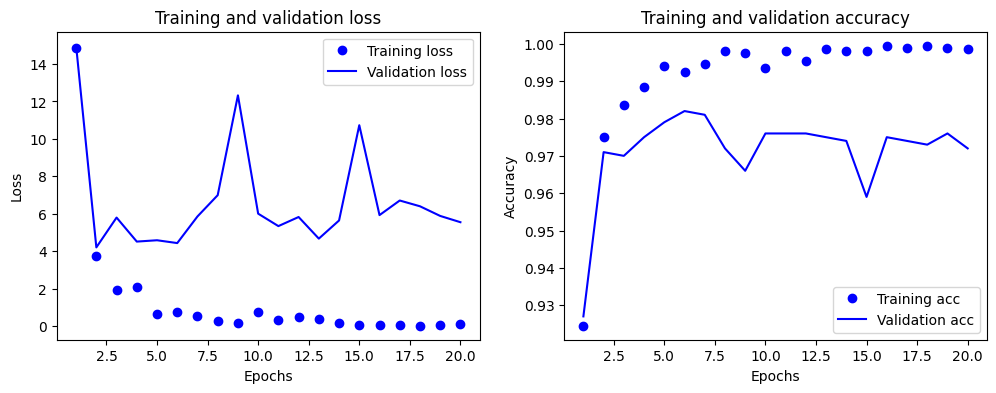

In [20]:
show_history(history)